In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [81]:
# load and set target
df = pd.read_csv("ThursMorn_WebAttacks.csv")

target = " Label"
X = df.drop(" Label", axis=1)
y = df[" Label"]

In [82]:
# encode categorical target
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y.astype(str))

# get rid of inf and replace with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [83]:
# split data 
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# randomized over sampling
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

In [84]:
# train rfc 
model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [85]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9951868518880845

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25228
           1       0.72      0.77      0.75       226
           2       0.67      0.67      0.67         3
           3       0.36      0.29      0.32        98

    accuracy                           1.00     25555
   macro avg       0.69      0.68      0.68     25555
weighted avg       0.99      1.00      1.00     25555


Confusion Matrix:
 [[25227     1     0     0]
 [    0   175     1    50]
 [    0     1     2     0]
 [    4    66     0    28]]


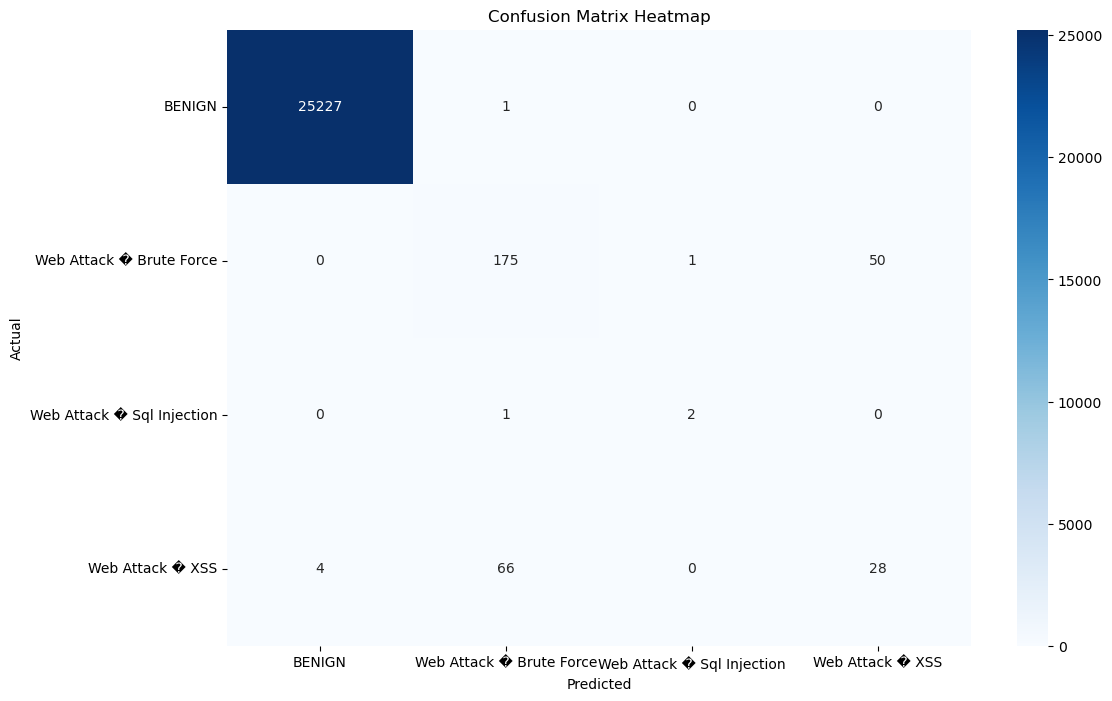

In [88]:
# call predictions (y_pred are label-encoded integers)
y_pred = model.predict(X_test)
if hasattr(model, "predict_proba") is False:  # round to nearest int
    y_pred = np.round(y_pred).astype(int)

# decode label-encoded target back to original strings
y_test_labels = le_y.inverse_transform(y_test)
y_pred_labels = le_y.inverse_transform(np.clip(y_pred, 0, len(le_y.classes_)-1))

# get all labels that appear in test or predictions
all_labels = sorted(list(set(y_test_labels) | set(y_pred_labels)))

# compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=all_labels)

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=all_labels,
            yticklabels=all_labels,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()
